## 1. Importing important price data
<p>Every time I go to the supermarket, my wallet weeps a little. But how expensive is food around the world? In this notebook, we'll explore time series of food prices in Rwanda from the <a href="https://data.humdata.org/dataset/wfp-food-prices">United Nations Humanitarian Data Exchange Global Food Price Database</a>. Agriculture makes up over 30% of Rwanda's economy, and over 60% of its export earnings (<a href="https://www.cia.gov/library/publications/the-world-factbook/geos/rw.html">CIA World Factbook</a>), so the price of food is very important to the livelihood of many Rwandans.</p>
<p>The map below shows the layout of Rwanda; it is split into five administrative regions. The central area around the Captial city, Kigali, is one region, and the others are North, East, South, and West.</p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_515/img/RwandaGeoProvinces.png" alt="A map of the five administrative regions of Rwanda"></p>
<p>In this notebook, we're going to import, manipulate, visualize and forecast Rwandan potato price data. We'll also wrap our analysis into functions to make it easy to analyze prices of other foods.</p>

In [2]:
# Load the readr and dplyr packages
library("readr")
library("dplyr")

# Import the potatoes dataset
potato_prices <- read_csv("datasets/Potatoes (Irish).csv")

# Take a glimpse at the contents
glimpse(potato_prices)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Parsed with column specification:
cols(
  adm0_id = col_integer(),
  adm0_name = col_character(),
  adm1_id = col_integer(),
  adm1_name = col_character(),
  mkt_id = col_integer(),
  mkt_name = col_character(),
  cm_id = col_integer(),
  cm_name = col_character(),
  cur_id = col_integer(),
  cur_name = col_character(),
  pt_id = col_integer(),
  pt_name = col_character(),
  um_id = col_integer(),
  um_name = col_character(),
  mp_month = col_integer(),
  mp_year = col_integer(),
  mp_price = col_double(),
  mp_commoditysource = col_character()
)


Observations: 4,320
Variables: 18
$ adm0_id            <int> 205, 205, 205, 205, 205, 205, 205, 205, 205, 205...
$ adm0_name          <chr> "Rwanda", "Rwanda", "Rwanda", "Rwanda", "Rwanda"...
$ adm1_id            <int> 21973, 21973, 21973, 21973, 21973, 21973, 21973,...
$ adm1_name          <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", ...
$ mkt_id             <int> 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, ...
$ mkt_name           <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Bir...
$ cm_id              <int> 148, 148, 148, 148, 148, 148, 148, 148, 148, 148...
$ cm_name            <chr> "Potatoes (Irish)", "Potatoes (Irish)", "Potatoe...
$ cur_id             <int> 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, ...
$ cur_name           <chr> "RWF", "RWF", "RWF", "RWF", "RWF", "RWF", "RWF",...
$ pt_id              <int> 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, ...
$ pt_name            <chr> "Retail", "Retail", "Retail", "Retail", "Retail"...
$ um_id           

## 2. Once more, with feeling
<p>Many of the columns in the potato data aren't very useful for our analysis. For example, the <code>adm1_name</code> column is always <code>"Rwanda"</code>, and <code>cur_name</code> is always <code>"RWF"</code>. (This is short for Rwandan Franc; for context, 1000 RWF is a little over 1 USD.) Similarly, we don't really need any of the ID columns or the data source.</p>
<p>Even the columns we do need have slightly obscure names. For example, <code>adm1_id</code> isn't as clear as <code>region</code>, and <code>mkt_name</code> isn't as clear as <code>market</code>. One of the most types of data analysis disaster is to misunderstand what a variable means, so naming variable clearly is a useful way to avoid this. One trick is that any variable that includes a unit should include that unit in the variable name. Here, the prices are given in Rwandan Francs, so <code>price_rwf</code> is a good name.</p>

In [35]:
# Import again, only reading specific columns
potato_prices <- read_csv("datasets/Potatoes (Irish).csv", 
                          col_types = cols_only(
                              adm1_name = "c", 
                              mkt_name="c", 
                              cm_name="c",
                              mp_month="i", 
                              mp_year="i", 
                              mp_price="d"))

# Rename the columns to be more informative
potato_prices_renamed <- rename(potato_prices, 
                                region=adm1_name, 
                                market=mkt_name, 
                                commodity_kg=cm_name, 
                                month=mp_month, 
                                year=mp_year, 
                                price_rwf=mp_price )

# Check the result
glimpse(potato_prices_renamed)
potato_prices_renamed %>% head()

Observations: 4,320
Variables: 6
$ region       <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", "$West...
$ market       <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Birambo",...
$ commodity_kg <chr> "Potatoes (Irish)", "Potatoes (Irish)", "Potatoes (Iri...
$ month        <int> 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3...
$ year         <int> 2010, 2010, 2011, 2011, 2011, 2011, 2011, 2011, 2011, ...
$ price_rwf    <dbl> 157.0000, 133.3333, 96.5000, 97.0000, 107.8000, 125.50...


region,market,commodity_kg,month,year,price_rwf
$West/Iburengerazuba,Birambo,Potatoes (Irish),11,2010,157.0000
$West/Iburengerazuba,Birambo,Potatoes (Irish),12,2010,133.3333
$West/Iburengerazuba,Birambo,Potatoes (Irish),1,2011,96.5000
$West/Iburengerazuba,Birambo,Potatoes (Irish),2,2011,97.0000
$West/Iburengerazuba,Birambo,Potatoes (Irish),3,2011,107.8000
$West/Iburengerazuba,Birambo,Potatoes (Irish),4,2011,125.5000


## 3. Spring cleaning
<p>As is often the case in a data analysis, the data we are given isn't in quite the form we'd like it to be. For example, we may have noticed in the last task that the month and year given as integers. Since we'll be performing some time series analysis, it would be helpful if they were provided as dates. Before we can analyze the data, we need to spring clean it.</p>

In [36]:
# Load lubridate
library(lubridate)
library(dplyr)

# Convert year and month to Date
potato_prices_cleaned <- potato_prices_renamed %>% 
                        # new column date, constructed from the year, the month and day - 01
                        mutate(date = ymd(paste(year, month, "01", sep="-"))) %>% 
                        select(-c(month, year)) # drop the year and month columns


# See the result
glimpse(potato_prices_cleaned)
potato_prices_cleaned %>% head()

Observations: 4,320
Variables: 5
$ region       <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", "$West...
$ market       <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Birambo",...
$ commodity_kg <chr> "Potatoes (Irish)", "Potatoes (Irish)", "Potatoes (Iri...
$ price_rwf    <dbl> 157.0000, 133.3333, 96.5000, 97.0000, 107.8000, 125.50...
$ date         <date> 2010-11-01, 2010-12-01, 2011-01-01, 2011-02-01, 2011-...


region,market,commodity_kg,price_rwf,date
$West/Iburengerazuba,Birambo,Potatoes (Irish),157.0000,2010-11-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),133.3333,2010-12-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),96.5000,2011-01-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),97.0000,2011-02-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),107.8000,2011-03-01
$West/Iburengerazuba,Birambo,Potatoes (Irish),125.5000,2011-04-01


## 4. Potatoes are not a balanced diet
<p>As versatile as potatoes are, with their ability to be boiled, roasted, mashed, fried, or chipped, the people of Rwanda have more varied culinary tastes. That means you are going to have to look at some other food types!</p>
<p>If we want to do a similar task many times, we could just cut and paste our code and change bits here and there. This is a terrible idea, since changing code in one place doesn't keep it up to date in the other places, and we quickly end up with lots of bugs.</p>
<p>A better idea is to write a function. That way we avoid cut and paste errors and can have more readable code.</p>

In [37]:
# Wrap this code into a function
read_price_data <- function(commodity){
    commodity_prices <- read_csv(eval( paste0("datasets/", commodity, ".csv") ),
    col_types = cols_only(
    adm1_name = col_character(),
    mkt_name = col_character(),
    cm_name = col_character(),
    mp_month = col_integer(),
    mp_year = col_integer(),
    mp_price = col_number()
  )
)
    commodity_prices_renamed <- commodity_prices %>% 
    rename(
    region = adm1_name, 
    market = mkt_name,
    commodity_kg = cm_name,
    month = mp_month,
    year = mp_year,
    price_rwf = mp_price
  )
    commodity_prices_cleaned <- commodity_prices_renamed %>% 
    mutate(date = ymd(paste(year, month, "01"))) %>% 
    select(-month, -year)
    
    return(commodity_prices_cleaned)
}

# Test it
pea_prices <- read_price_data(commodity = "Peas (fresh)")
glimpse(pea_prices)

Observations: 1,893
Variables: 5
$ region       <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", "$West...
$ market       <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Birambo",...
$ commodity_kg <chr> "Peas (fresh)", "Peas (fresh)", "Peas (fresh)", "Peas ...
$ price_rwf    <dbl> 403.5000, 380.0000, 277.5000, 450.0000, 450.0000, 375....
$ date         <date> 2011-01-01, 2011-02-01, 2011-04-01, 2011-05-01, 2011-...


## 5. Plotting the price of potatoes
<p>A great first step in any data analysis is to look at the data. In this case, we have some prices, and we have some dates, so the obvious thing to do is to see how those prices change over time.</p>

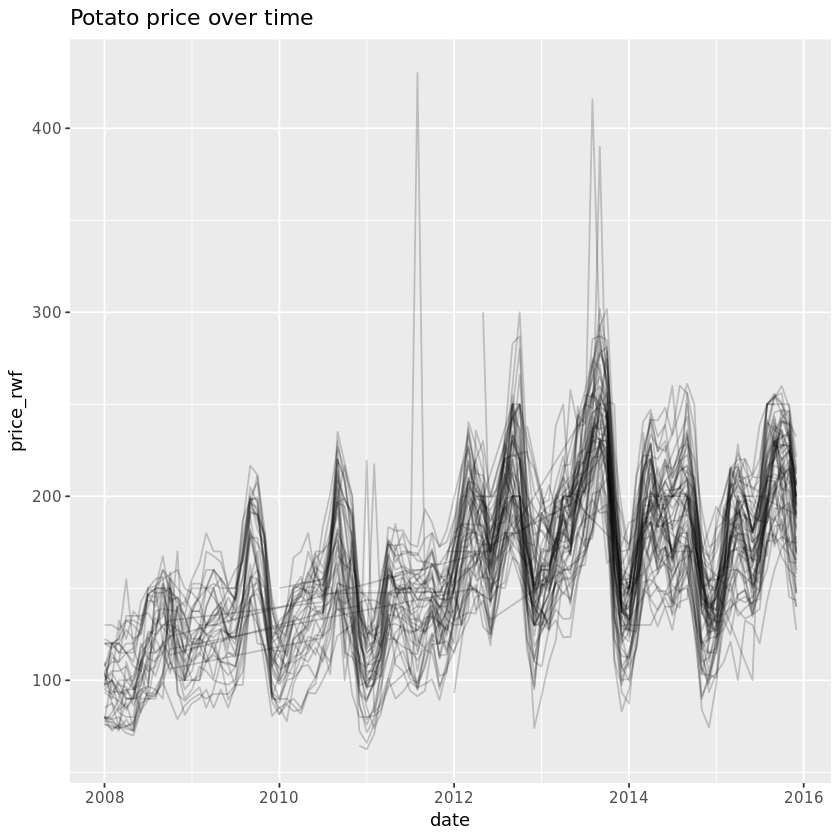

In [14]:
# Load ggplot2
library(ggplot2)

# Draw a line plot of price vs. date grouped by market 
ggplot(data = potato_prices_cleaned, aes(x = date, y = price_rwf, group = market)) +
      geom_line(alpha=.2) + 
      ggtitle("Potato price over time")

## 6. What a lotta plots
<p>There is a bit of a trend in the potato prices, with them increasing until 2013, after which they level off. More striking though is the seasonality: the prices are lowest around December and January, and have a peak around August. Some years also show a second peak around April or May.</p>
<p>Just as with the importing and cleaning code, if we want to make lots of similar plots, we need to wrap the plotting code into a function.</p>

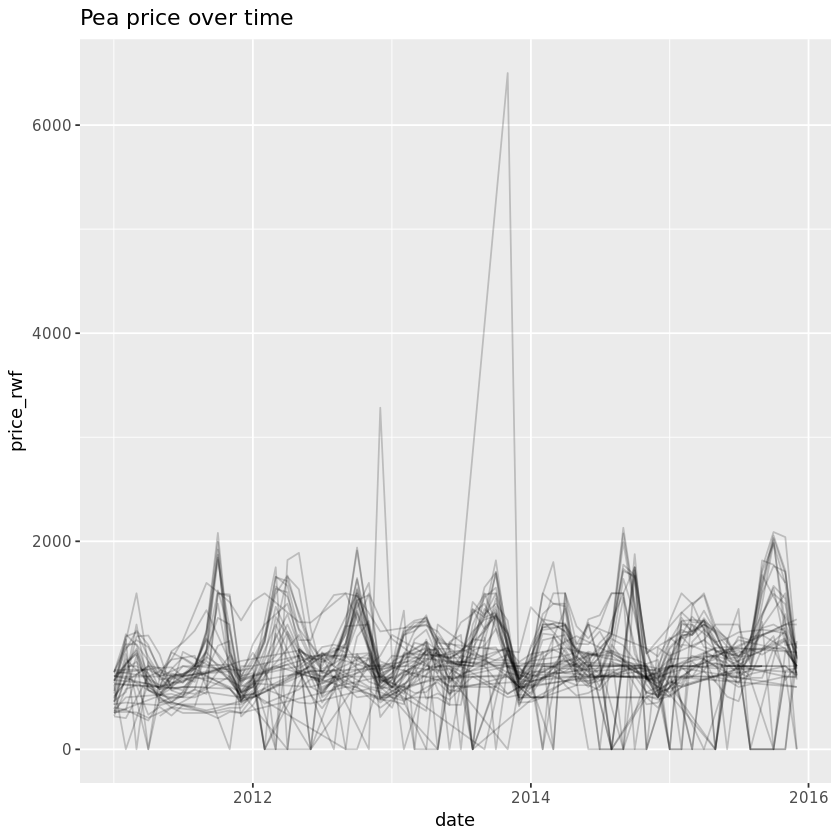

In [16]:
# Wrap this code into a function
plot_price_vs_time <- function(prices, commodity) {
    prices %>% 
    ggplot(aes(date, price_rwf, group = market)) +
    geom_line(alpha = .2) +
    ggtitle(paste(commodity, "price over time"))
}

# Try the function on the pea data
plot_price_vs_time(pea_prices, "Pea")

## 7. Preparing to predict the future (part 1)
<p>While it's useful to see how the prices have changed in the past, what's more exciting is to forecast how they will change in the future. Before we get to that, there are some data preparation steps that need to be performed.</p>
<p>The datasets for each commodity are very rich: rather than being a single time series, they consist of a time series for each market. The fancy way of analyzing this is to treat it as a single hierarchical time series. The easier way that we'll try here, is to take the average price across markets at each time and analyze the resulting single time series.</p>
<p>Looking at the plots from the potato and pea datasets, we can see that occasionally there is a big spike in the price. That probably indicates a logistic problem where that food wasn't easily available at a particular market, or the buyer looked like a tourist and got ripped off. The consequence of these outliers is that it is a bad idea to use the <em>mean</em> price of each time point: instead, the <em>median</em> makes more sense since it is robust against outliers.</p>

In [26]:
# Group by date, and calculate the median price
potato_prices_summarized <- potato_prices_cleaned %>% 
                                    group_by(date) %>% 
                                    summarize(median_price_rwf = median(price_rwf))

# See the result
glimpse(potato_prices_summarized)
potato_prices_summarized %>% head()

Observations: 96
Variables: 2
$ date             <date> 2008-01-01, 2008-02-01, 2008-03-01, 2008-04-01, 2...
$ median_price_rwf <dbl> 97.5000, 100.0000, 95.0000, 96.2500, 95.0000, 110....


date,median_price_rwf
2008-01-01,97.50
2008-02-01,100.00
2008-03-01,95.00
2008-04-01,96.25
2008-05-01,95.00
2008-06-01,110.00


## 8. Preparing to predict the future (part 2)
<p>Time series analysis in R is at a crossroads. The best and most mature tools for analysis are based around a time series data type called <code>ts</code>, which predates the tidyverse by several decades. That means that we have to do one more data preparation step before we can start forecasting: we need to convert our summarized dataset into a <code>ts</code> object.</p>

In [29]:
# Load magrittr
library(magrittr)

# Extract a time series
potato_time_series <- potato_prices_summarized %$%
    ts(
       median_price_rwf,
       start = c(year(min(date)), month(min(date))),
       end   = c(year(max(date)), month(max(date))),
       frequency = 12
    )


# See the result
glimpse(potato_time_series)
potato_time_series

 Time-Series [1:96] from 2008 to 2016: 97.5 100 95 96.2 95 ...


          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
2008  97.5000 100.0000  95.0000  96.2500  95.0000 110.0000 116.6667 125.0000
2009 120.0000 122.5000 130.0000 131.2500 135.0000 124.3125 125.8333 144.2500
2010 109.6875 113.5000 131.2500 132.0833 140.4167 147.3750 142.5000 161.5000
2011 105.7000 108.1750 118.8750 145.0143 148.6667 148.0500 137.4048 137.2619
2012 150.7500 175.2500 186.0139 186.2500 182.5000 162.7500 179.1250 196.9643
2013 154.3333 157.0000 171.2500 187.5000 177.0000 202.2500 210.0000 233.1875
2014 138.3333 158.7500 186.2500 198.2500 191.0000 189.3333 182.5000 187.6191
2015 136.2500 157.6071 178.0000 190.2778 179.3750 168.3333 180.0000 202.1250
          Sep      Oct      Nov      Dec
2008 136.2500 130.0000 127.5000 114.3750
2009 181.2500 170.0000 150.2500 112.0000
2010 182.4000 162.5000 151.5000 122.5000
2011 141.6667 144.2000 133.1750 141.5000
2012 226.5000 203.5000 169.2500 144.0000
2013 241.3333 237.5000 176.7083 140.0000
2014 200.0000 183.13

## 9. Another day, another function to write
<p>Those data preparation steps were tricky! Wouldn't it be really nice if we never had to write them again? Well, if we wrap that code into a function, then we won't have to.</p>

In [27]:
# Wrap this code into a function
create_price_time_series <- function(price_data){ 
  prices_summarized <- price_data %>%
      group_by(date) %>% 
      summarize(median_price_rwf = median(price_rwf))

  time_series <- prices_summarized %$% 
      ts(
      median_price_rwf, 
      start = c(year(min(date))), month(min(date)), 
      end   = c(year(max(date))), month(max(date)), 
      frequency = 12
   )
}

# Try the function on the pea data
pea_time_series <- create_price_time_series(pea_prices)
pea_time_series

           Jan       Feb       Mar       Apr       May       Jun       Jul
2011  561.6667  691.6667  937.5000  689.5000  591.5000  597.8572  666.3572
2012  655.0000  774.7500 1272.1667 1166.0000  945.8750  800.0000  714.2857
2013  668.7500  741.6667  800.0000  956.2500  890.0000  775.4375  806.3750
2014  695.5000  995.0000 1131.2500 1083.2500  825.0000  800.0000  766.6667
2015  790.4286                                                            
           Aug       Sep       Oct       Nov       Dec
2011  758.5000  938.8333 1506.2500  765.1667  548.9375
2012  771.4583  957.5000 1413.7500  952.8333  661.8571
2013  971.4286 1162.4583 1316.7500  911.3333  623.8571
2014  933.8333  900.0000 1658.3333  687.5000  633.3333
2015                                                  

## 10. The future of potato prices
<p>All the preparation is done and we are ready to start forecasting. One question we might ask is "how do I know if I can trust our forecast?". Recall that both the potato and the pea data had strong seasonality (for example, potatoes were most expensive around August and cheapest around December). For agricultural data, a good forecast should show a similar shape throughout the seasons.</p>
<p>Now then, are we ready to see the future?</p>

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Jan 2016       190.0093 171.35706 208.6615 161.48317 218.5354
Feb 2016       202.6099 174.14582 231.0740 159.07783 246.1420
Mar 2016       220.0317 181.72222 258.3413 161.44238 278.6211
Apr 2016       231.5932 184.48380 278.7026 159.54559 303.6408
May 2016       226.2626 174.20438 278.3209 146.64641 305.8789
Jun 2016       229.1587 170.73454 287.5829 139.80665 318.5108
Jul 2016       230.8787 166.57270 295.1848 132.53113 329.2263
Aug 2016       251.1739 175.53815 326.8096 135.49902 366.8487
Sep 2016       279.3573 189.13187 369.5827 141.36943 417.3451
Oct 2016       262.7887 172.33073 353.2467 124.44516 401.1323
Nov 2016       236.0485 149.89274 322.2042 104.28465 367.8123
Dec 2016       205.0924 126.05584 284.1290  84.21640 325.9684
Jan 2017       205.0036 121.88813 288.1190  77.88948 332.1177
Feb 2017       218.4941 125.58323 311.4050  76.39917 360.5891
Mar 2017       237.1698 131.67270 342.6669  75.82591 398.5137
Apr 2017

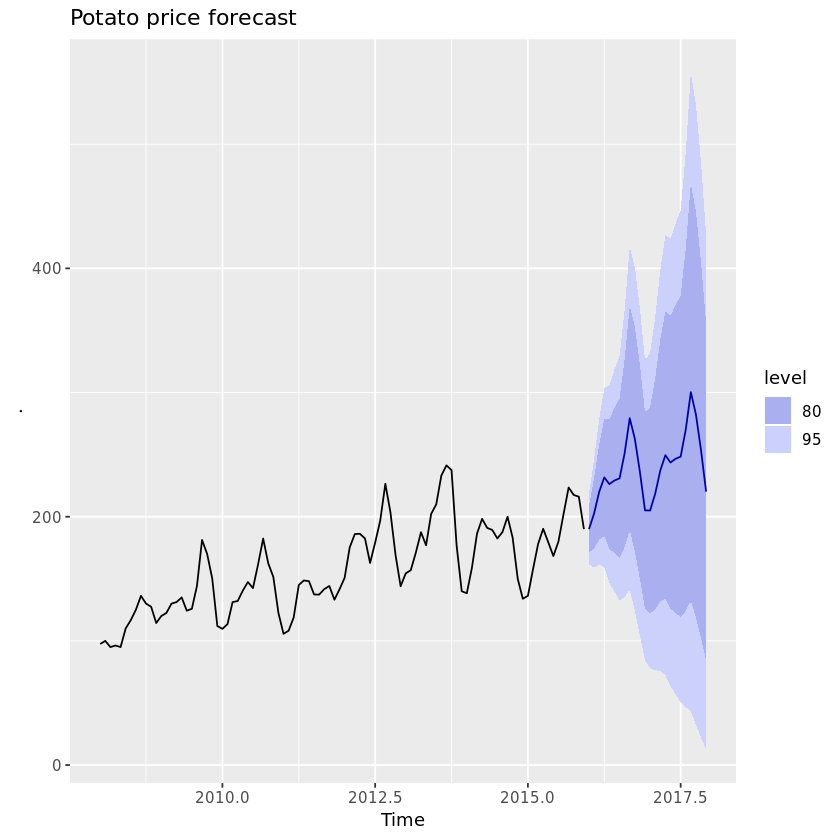

In [31]:
# Load forecast
library(forecast)

# Forecast the potato time series
potato_price_forecast <- potato_time_series %>% forecast()

# View it
potato_price_forecast

# Plot the forecast
potato_price_forecast %>% autoplot(main = "Potato price forecast")

## 11. The final function
<p>Nice! The forecast shows the spike in potato prices in late summer and the dip toward the end of the year.</p>
<p>With this analysis step, just as the previous steps, to make things repeatable, we need to wrap the code into a function.</p>

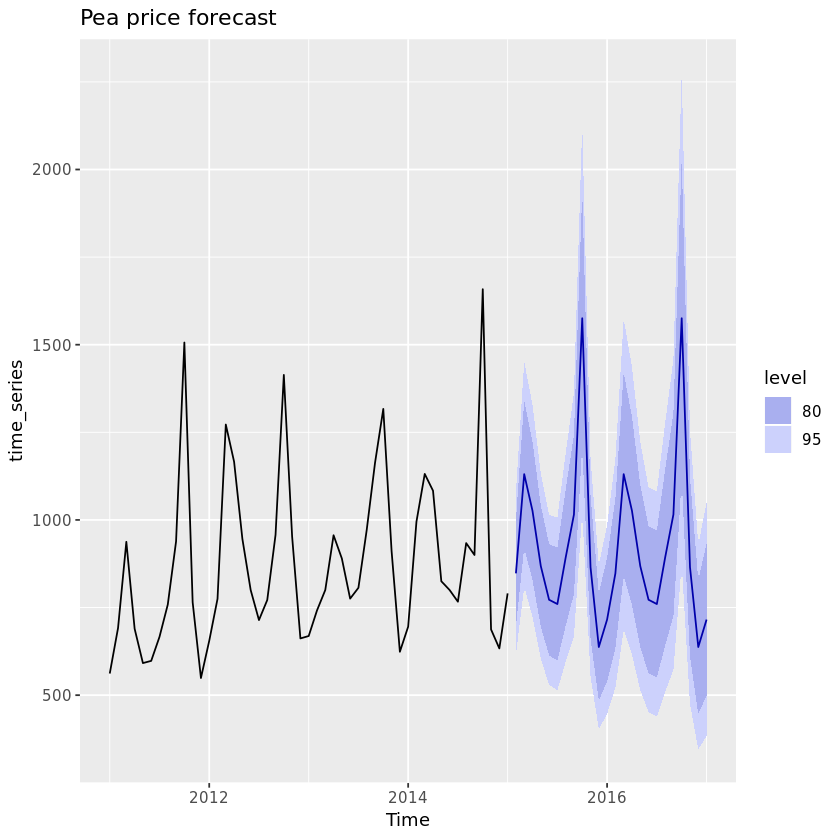

In [32]:
# Wrap the code into a function
plot_price_forecast <- function(time_series, commodity) {
    price_forecast <- forecast(time_series)
    autoplot(price_forecast, main = paste(commodity, "price forecast"))
}
# Try the function on the pea data
plot_price_forecast(pea_time_series, "Pea")

## 12. Do it all over again
<p>That was a lot of effort writing all that code to analyze the potato data. Fortunately, since we wrapped all the code into functions, we can easily take a look at any other food type.</p>

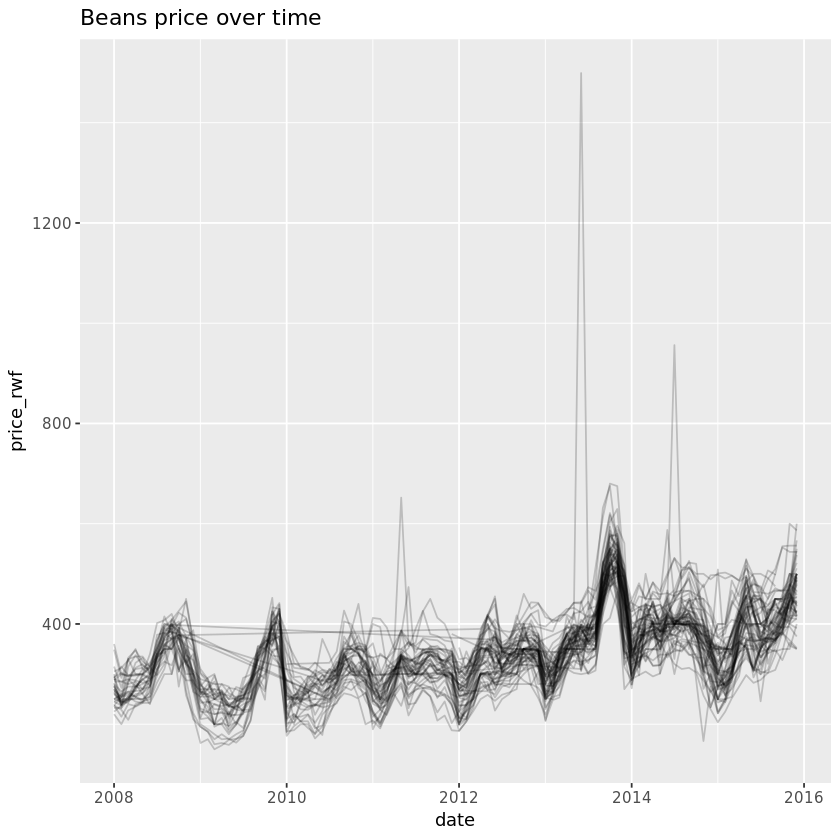

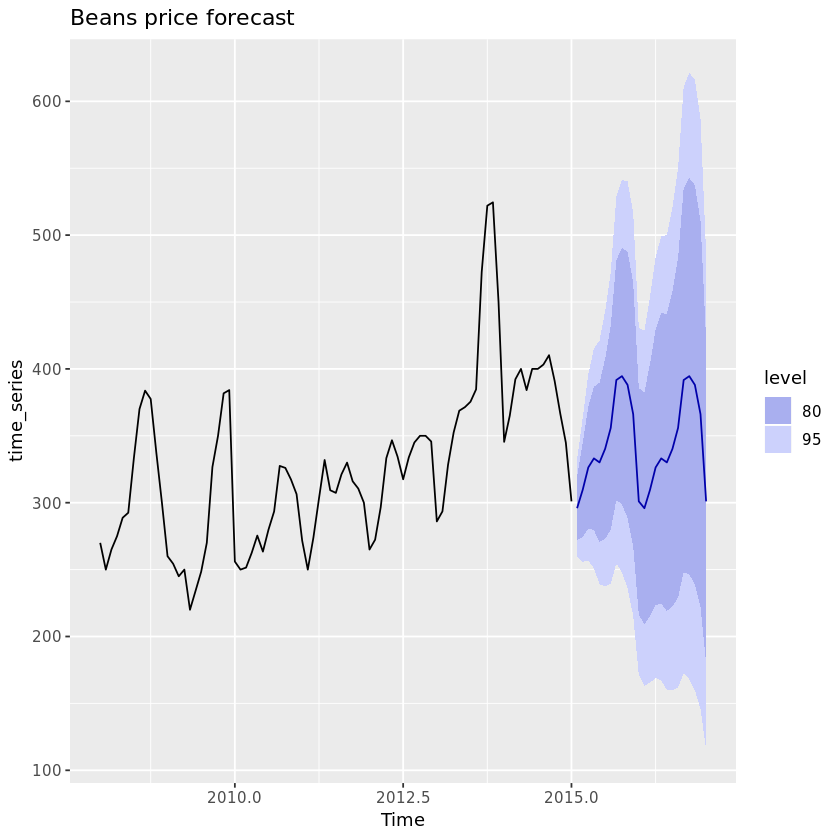

In [34]:
# Choose dry beans as the commodity
commodity <- "Beans (dry)"

# Read the price data
bean_prices <- read_price_data(commodity)

# Plot price vs. time
plot_price_vs_time(bean_prices, "Beans")

# Create a price time series
bean_time_series <- create_price_time_series(bean_prices)

# Plot the price forecast
plot_price_forecast(bean_time_series, "Beans")